<a href="https://colab.research.google.com/github/iam-pattan/SRGANs/blob/main/SRGAN_Exploring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

`Reference Code`

https://hub.packtpub.com/using-srgans-to-generate-photo-realistic-images-tutorial/

https://github.com/eriklindernoren/Keras-GAN/blob/master/srgan/srgan.py

https://manishdhakal.medium.com/super-resolution-with-gan-and-keras-srgan-4bd810d214b6

https://github.com/PacktPublishing/Generative-Adversarial-Networks-Projects/blob/master/Chapter05/run.py

`Reference Articles`

https://medium.com/@birla.deepak26/single-image-super-resolution-using-gans-keras-aca310f33112

https://irenesz.medium.com/super-resolution-with-srgan-afd140ca054d

https://github.com/deepak112/Keras-SRGAN

Reference Articles

https://medium.com/@birla.deepak26/single-image-super-resolution-using-gans-keras-aca310f33112

https://irenesz.medium.com/super-resolution-with-srgan-afd140ca054d

https://github.com/deepak112/Keras-SRGAN



In [ ]:
import glob
import time

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import Input
from keras.applications import VGG19
from keras.callbacks import TensorBoard
from keras.layers import BatchNormalization, Activation, LeakyReLU, Add, Dense
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam
from keras_preprocessing.image import img_to_array, load_img

In [ ]:
!wget 'https://github.com/OlafenwaMoses/IdenProf/releases/download/v1.0/idenprof-jpg.zip'
!unzip '/content/idenprof-jpg.zip'

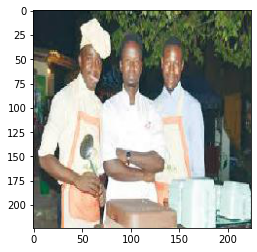

In [ ]:
data_dir = '/content/idenprof/train/chef/*.*'
all_images = glob.glob(data_dir)
pth = np.random.choice(all_images, size=1)
img = plt.imread(pth[0])
plt.imshow(img)

In [ ]:
def residual_block(x):
    """
    Residual block
    """
    filters = [64, 64]
    kernel_size = 3
    strides = 1
    padding = "same"
    momentum = 0.8
    activation = "relu"

    res = Conv2D(filters=filters[0], kernel_size=kernel_size, strides=strides, padding=padding)(x)
    res = Activation(activation=activation)(res)
    res = BatchNormalization(momentum=momentum)(res)

    res = Conv2D(filters=filters[1], kernel_size=kernel_size, strides=strides, padding=padding)(res)
    res = BatchNormalization(momentum=momentum)(res)

    # Add res and x
    res = Add()([res, x])
    return res

In [ ]:
def build_generator():
    """
    Create a generator network using the hyperparameter values defined below
    :return:
    """
    residual_blocks = 16
    momentum = 0.8
    input_shape = (64, 64, 3)

    # Input Layer of the generator network
    input_layer = Input(shape=input_shape)

    # Add the pre-residual block
    gen1 = Conv2D(filters=64, kernel_size=9, strides=1, padding='same', activation='relu')(input_layer)

    # Add 16 residual blocks
    res = residual_block(gen1)
    for i in range(residual_blocks - 1):
        res = residual_block(res)

    # Add the post-residual block
    gen2 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(res)
    gen2 = BatchNormalization(momentum=momentum)(gen2)

    # Take the sum of the output from the pre-residual block(gen1) and the post-residual block(gen2)
    gen3 = Add()([gen2, gen1])

    # Add an upsampling block
    gen4 = UpSampling2D(size=2)(gen3)
    gen4 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen4)
    gen4 = Activation('relu')(gen4)

    # Add another upsampling block
    gen5 = UpSampling2D(size=2)(gen4)
    gen5 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen5)
    gen5 = Activation('relu')(gen5)

    # Output convolution layer
    gen6 = Conv2D(filters=3, kernel_size=9, strides=1, padding='same')(gen5)
    output = Activation('tanh')(gen6)

    # Keras model
    model = Model(inputs=[input_layer], outputs=[output], name='generator')
    return model

In [ ]:
def build_discriminator():
    """
    Create a discriminator network using the hyperparameter values defined below
    :return:
    """
    leakyrelu_alpha = 0.2
    momentum = 0.8
    input_shape = (256, 256, 3)

    input_layer = Input(shape=input_shape)

    # Add the first convolution block
    dis1 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(input_layer)
    dis1 = LeakyReLU(alpha=leakyrelu_alpha)(dis1)

    # Add the 2nd convolution block
    dis2 = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(dis1)
    dis2 = LeakyReLU(alpha=leakyrelu_alpha)(dis2)
    dis2 = BatchNormalization(momentum=momentum)(dis2)

    # Add the third convolution block
    dis3 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(dis2)
    dis3 = LeakyReLU(alpha=leakyrelu_alpha)(dis3)
    dis3 = BatchNormalization(momentum=momentum)(dis3)

    # Add the fourth convolution block
    dis4 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same')(dis3)
    dis4 = LeakyReLU(alpha=leakyrelu_alpha)(dis4)
    dis4 = BatchNormalization(momentum=0.8)(dis4)

    # Add the fifth convolution block
    dis5 = Conv2D(256, kernel_size=3, strides=1, padding='same')(dis4)
    dis5 = LeakyReLU(alpha=leakyrelu_alpha)(dis5)
    dis5 = BatchNormalization(momentum=momentum)(dis5)

    # Add the sixth convolution block
    dis6 = Conv2D(filters=256, kernel_size=3, strides=2, padding='same')(dis5)
    dis6 = LeakyReLU(alpha=leakyrelu_alpha)(dis6)
    dis6 = BatchNormalization(momentum=momentum)(dis6)

    # Add the seventh convolution block
    dis7 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(dis6)
    dis7 = LeakyReLU(alpha=leakyrelu_alpha)(dis7)
    dis7 = BatchNormalization(momentum=momentum)(dis7)

    # Add the eight convolution block
    dis8 = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')(dis7)
    dis8 = LeakyReLU(alpha=leakyrelu_alpha)(dis8)
    dis8 = BatchNormalization(momentum=momentum)(dis8)

    # Add a dense layer
    dis9 = Dense(units=1024)(dis8)
    dis9 = LeakyReLU(alpha=0.2)(dis9)

    # Last dense layer - for classification
    output = Dense(units=1, activation='sigmoid')(dis9)

    model = Model(inputs=[input_layer], outputs=[output], name='discriminator')
    return model

In [ ]:
def build_vgg():
    """
    Build VGG network to extract image features
    """
    input_shape = (256, 256, 3)

    # Load a pre-trained VGG19 model trained on 'Imagenet' dataset
    vgg = VGG19(weights="imagenet")
    vgg.outputs = [vgg.layers[9].output]

    input_layer = Input(shape=input_shape)

    # Extract features
    features = vgg(input_layer)

    # Create a Keras model
    model = Model(inputs=[input_layer], outputs=[features])
    return model

In [ ]:
def sample_images(data_dir, batch_size, high_resolution_shape, low_resolution_shape):
    # Make a list of all images inside the data directory
    all_images = glob.glob(data_dir)

    # Choose a random batch of images
    images_batch = np.random.choice(all_images, size=batch_size)

    low_resolution_images = []
    high_resolution_images = []

    for img in images_batch:
        # Get an ndarray of the current image
        img1 = plt.imread(img)
        img1 = img1.astype(np.float32)

        # Resize the image
        img1_high_resolution = resize(img1, high_resolution_shape)
        img1_low_resolution = resize(img1, low_resolution_shape)

        # Do a random flip
        if np.random.random() < 0.5:
            img1_high_resolution = np.fliplr(img1_high_resolution)
            img1_low_resolution = np.fliplr(img1_low_resolution)

        high_resolution_images.append(img1_high_resolution)
        low_resolution_images.append(img1_low_resolution)

    return np.array(high_resolution_images), np.array(low_resolution_images)

In [ ]:
def save_images(low_resolution_image, original_image, generated_image, path):
    """
    Save low-resolution, high-resolution(original) and
    generated high-resolution images in a single image
    """
    fig = plt.figure()
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(low_resolution_image)
    ax.axis("off")
    ax.set_title("Low-resolution")

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(original_image)
    ax.axis("off")
    ax.set_title("Original")

    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(generated_image)
    ax.axis("off")
    ax.set_title("Generated")

    plt.savefig(path)

In [ ]:
def write_log(callback, name, value, batch_no):
    """
    Write scalars to Tensorboard
    """
    summary = tf.Summary()
    summary_value = summary.value.add()
    summary_value.simple_value = value
    summary_value.tag = name
    callback.writer.add_summary(summary, batch_no)
    callback.writer.flush()

In [ ]:
if __name__ == '__main__':
# Define hyperparameters
    data_dir = '/content/idenprof/train/chef/*.*'
    epochs = 20000
    batch_size = 1
    mode = 'train'

    # Shape of low-resolution and high-resolution images
    low_resolution_shape = (64, 64, 3)
    high_resolution_shape = (256, 256, 3)

    # Common optimizer for all networks
    common_optimizer = Adam(0.0002, 0.5)    

    if mode == 'train':
        # Build and compile VGG19 network to extract features
        vgg = build_vgg()
        vgg.trainable = False
        vgg.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

        # Build and compile the discriminator network
        discriminator = build_discriminator()
        discriminator.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

        # Build the generator network
        generator = build_generator()

        """
        Build and compile the adversarial model
        """

        # Input layers for high-resolution and low-resolution images
        input_high_resolution = Input(shape=high_resolution_shape)
        input_low_resolution = Input(shape=low_resolution_shape)

        # Generate high-resolution images from low-resolution images
        generated_high_resolution_images = generator(input_low_resolution)

        # Extract feature maps of the generated images
        features = vgg(generated_high_resolution_images)

        # Make the discriminator network as non-trainable
        discriminator.trainable = False

        # Get the probability of generated high-resolution images
        probs = discriminator(generated_high_resolution_images)

        # Create and compile an adversarial model
        adversarial_model = Model([input_low_resolution, input_high_resolution], [probs, features])
        adversarial_model.compile(loss=['binary_crossentropy', 'mse'], loss_weights=[1e-3, 1], optimizer=common_optimizer)

        # Add Tensorboard
        tensorboard = TensorBoard(log_dir="logs/".format(time.time()))
        tensorboard.set_model(generator)
        tensorboard.set_model(discriminator)

        for epoch in range(epochs):
            print("Epoch:{}".format(epoch))

            """
            Train the discriminator network
            """

            # Sample a batch of images
            high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=batch_size,
                                                                          low_resolution_shape=low_resolution_shape,
                                                                          high_resolution_shape=high_resolution_shape)
            # Normalize images
            high_resolution_images = high_resolution_images / 127.5 - 1.
            low_resolution_images = low_resolution_images / 127.5 - 1.

            # Generate high-resolution images from low-resolution images
            generated_high_resolution_images = generator.predict(low_resolution_images)

            # Generate batch of real and fake labels
            real_labels = np.ones((batch_size, 16, 16, 1))
            fake_labels = np.zeros((batch_size, 16, 16, 1))

            # Train the discriminator network on real and fake images
            d_loss_real = discriminator.train_on_batch(high_resolution_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(generated_high_resolution_images, fake_labels)

            # Calculate total discriminator loss
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            print("d_loss:", d_loss)

            """
            Train the generator network
            """

            # Sample a batch of images
            high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=batch_size,
                                                                          low_resolution_shape=low_resolution_shape,
                                                                          high_resolution_shape=high_resolution_shape)
            # Normalize images
            high_resolution_images = high_resolution_images / 127.5 - 1.
            low_resolution_images = low_resolution_images / 127.5 - 1.

            # Extract feature maps for real high-resolution images
            image_features = vgg.predict(high_resolution_images)

            # Train the generator network
            g_loss = adversarial_model.train_on_batch([low_resolution_images, high_resolution_images],
                                             [real_labels, image_features])

            print("g_loss:", g_loss)

            # Write the losses to Tensorboard
            write_log(tensorboard, 'g_loss', g_loss[0], epoch)
            write_log(tensorboard, 'd_loss', d_loss[0], epoch)

            # Sample and save images after every 100 epochs
            if epoch % 100 == 0:
                high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=batch_size,
                                                                              low_resolution_shape=low_resolution_shape,
                                                                              high_resolution_shape=high_resolution_shape)
                # Normalize images
                high_resolution_images = high_resolution_images / 127.5 - 1.
                low_resolution_images = low_resolution_images / 127.5 - 1.

                generated_images = generator.predict_on_batch(low_resolution_images)

                for index, img in enumerate(generated_images):
                    save_images(low_resolution_images[index], high_resolution_images[index], img,
                                path="results/img_{}_{}".format(epoch, index))

        # Save models
        generator.save_weights("generator.h5")
        discriminator.save_weights("discriminator.h5")

    if mode == 'predict':
        # Build and compile the discriminator network
        discriminator = build_discriminator()

        # Build the generator network
        generator = build_generator()

        # Load models
        generator.load_weights("generator.h5")
        discriminator.load_weights("discriminator.h5")

        # Get 10 random images
        high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=10,
                                                                      low_resolution_shape=low_resolution_shape,
                                                                      high_resolution_shape=high_resolution_shape)
        # Normalize images
        high_resolution_images = high_resolution_images / 127.5 - 1.
        low_resolution_images = low_resolution_images / 127.5 - 1.

        # Generate high-resolution images from low-resolution images
        generated_images = generator.predict_on_batch(low_resolution_images)

        # Save images
        for index, img in enumerate(generated_images):
            save_images(low_resolution_images[index], high_resolution_images[index], img,
                        path="results/gen_{}".format(index))
        